# Lectura 33: Lazy API - Plan y ejecución de una consulta

## Plan de consulta

Para cualquier consulta lazy, Polars tiene ambos:

- **Un plan no optimizado:** este contiene el conjunto de pasos en código qu ele proporcionamos.
- **Un plan optimizado:** que contiene cambios realizados por el optimizador de consultas

Consideremos la siguiente consulta:

In [1]:
import polars as pl
from polars import col

query = (
    pl.scan_parquet('./data/vuelos/vuelos.parquet')
    .with_columns(tiempo_aire_hrs=(col('AIR_TIME') / 60))
    .filter(col('MONTH') > 7)
)

Primero visualizaremos el plan no optimizado con la función `show_graph` estableciendo el parámetro `optimized=False`.

**Nota Importante:**

Para visualizar los gráficos será necesario instalar la librería `graphviz` la cual la podemos instalar ejecutando en una celda de código el comando `pip install graphviz`. Además, necesitará instalar el programa `graphviz` en su sistema operativo.

**Para errores y dudas pueden visitar el siguiente enlace:**

(Solución de errores graphviz)[https://stackoverflow.com/questions/35064304/runtimeerror-make-sure-the-graphviz-executables-are-on-your-systems-path-aft]

In [2]:
# Descomentar y ejecutar solo si no está instalada la librería graphviz
# !pip3 install graphviz

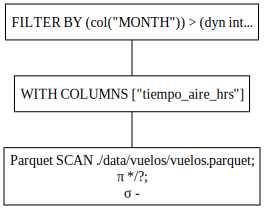

In [3]:
query.show_graph(optimized=False)

La visualización del plan de consulta debe leerse de abajo hacia arriba. Expliquemos como leer esta salida:

- Cada rectángulo corresponde a una etapa del plan de consulta
- El `sigma` significa SELECCIÓN e indica cualquier condición de filtro
- El `pi` significa PROYECCIÓN e indica la elección de un subconjunto de columnas

Ahora visualizaremos el pan de consulta optimizado.

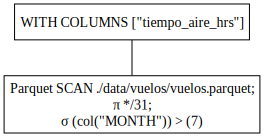

In [4]:
query.show_graph()

### Imprimir el plan de consulta

También podemos imprimir el plan no optimizado con `explain(optimized=False)`.

In [6]:
print(query.explain(optimized=False))

FILTER [(col("MONTH")) > (dyn int: 7)] FROM
 WITH_COLUMNS:
 [[(col("AIR_TIME")) / (dyn int: 60)].alias("tiempo_aire_hrs")]

    Parquet SCAN ./data/vuelos/vuelos.parquet
    PROJECT */? COLUMNS


Imprimamos el plan de consulta optimizado.

In [8]:
print(query.explain())

 WITH_COLUMNS:
 [[(col("AIR_TIME")) / (60)].alias("tiempo_aire_hrs")]

    Parquet SCAN ./data/vuelos/vuelos.parquet
    PROJECT */31 COLUMNS
    SELECTION: [(col("MONTH")) > (7)]


## Ejecución de una consulta

In [9]:
query = (
    pl.scan_parquet('./data/vuelos/vuelos.parquet')
    .with_columns(tiempo_aire_hrs=(col('AIR_TIME') / 60))
    .filter(col('MONTH') > 7)
)

Si tuviéramos que ejecutar el código anterior en el dataset de vuelos, la consulta no se evaluaría. En cambio, Polars toma cada línea de código, la agrega al gráfico de consulta interno y lo optimiza.

Cuando ejecutamos el código, Polars ejecuta el gráfico de consulta optimizado de forma predeterminada.

Podemos ejecutar nuestra consulta en el conjunto de datos completo llamando al método `.collect` en la consulta.

In [10]:
query = (
    pl.scan_parquet('./data/vuelos/vuelos.parquet')
    .with_columns(tiempo_aire_hrs=(col('AIR_TIME') / 60))
    .filter(col('MONTH') > 7)
    .collect()
)

query

YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,tiempo_aire_hrs
i32,i32,i32,i32,str,i32,str,str,str,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,str,i32,i32,i32,i32,i32,f64
2015,8,1,6,"""NK""",298,"""N614NK""","""LAS""","""IAH""",3,55,52,12,107,177,173,153,1222,540,8,500,548,48,0,0,null,48,0,0,0,0,2.55
2015,8,1,6,"""AA""",1965,"""N587UW""","""SFO""","""CLT""",5,16,11,17,33,303,291,260,2296,753,14,808,807,-1,0,0,null,null,null,null,null,null,4.333333
2015,8,1,6,"""NK""",612,"""N631NK""","""LAS""","""MSP""",5,37,32,11,48,175,165,149,1299,517,5,500,522,22,0,0,null,22,0,0,0,0,2.483333
2015,8,1,6,"""AA""",260,"""N3BPAA""","""LAX""","""MIA""",10,8,-2,23,31,312,307,278,2342,809,6,822,815,-7,0,0,null,null,null,null,null,null,4.633333
2015,8,1,6,"""AA""",448,"""N165US""","""SLC""","""CLT""",15,54,39,16,110,234,219,198,1727,628,5,609,633,24,0,0,null,0,0,2,22,0,3.3
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2015,12,31,4,"""B6""",688,"""N657JB""","""LAX""","""BOS""",2359,2355,-4,22,17,320,298,272,2611,749,4,819,753,-26,0,0,null,null,null,null,null,null,4.533333
2015,12,31,4,"""B6""",745,"""N828JB""","""JFK""","""PSE""",2359,2355,-4,17,12,227,215,195,1617,427,3,446,430,-16,0,0,null,null,null,null,null,null,3.25
2015,12,31,4,"""B6""",1503,"""N913JB""","""JFK""","""SJU""",2359,2350,-9,17,7,221,222,197,1598,424,8,440,432,-8,0,0,null,null,null,null,null,null,3.283333


Con el método por defecto collect, Polars procesa todos sus datos como un solo lote. Esto significa que todos los datos deben caber en la memoria disponible en el punto de mayor uso de la memoria en la consulta.

## Ejecución en datos más grandes que la memoria

Si nuestros datos requieren más memoria de la que tenemos disponible, es posible que Polars pueda procesar los datos en lotes  (batches en inglés) utilizando el modo de streaming. Para usar el modo streaming simplemente pasamos el argumento `streaming=True` a `collect`.

In [11]:
query = (
    pl.scan_parquet('./data/vuelos/vuelos.parquet')
    .with_columns(tiempo_aire_hrs=(col('AIR_TIME') / 60))
    .filter(col('MONTH') > 7)
    .collect(streaming=True)
)

query

YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,tiempo_aire_hrs
i32,i32,i32,i32,str,i32,str,str,str,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,str,i32,i32,i32,i32,i32,f64
2015,8,1,6,"""NK""",298,"""N614NK""","""LAS""","""IAH""",3,55,52,12,107,177,173,153,1222,540,8,500,548,48,0,0,null,48,0,0,0,0,2.55
2015,8,1,6,"""AA""",1965,"""N587UW""","""SFO""","""CLT""",5,16,11,17,33,303,291,260,2296,753,14,808,807,-1,0,0,null,null,null,null,null,null,4.333333
2015,8,1,6,"""NK""",612,"""N631NK""","""LAS""","""MSP""",5,37,32,11,48,175,165,149,1299,517,5,500,522,22,0,0,null,22,0,0,0,0,2.483333
2015,8,1,6,"""AA""",260,"""N3BPAA""","""LAX""","""MIA""",10,8,-2,23,31,312,307,278,2342,809,6,822,815,-7,0,0,null,null,null,null,null,null,4.633333
2015,8,1,6,"""AA""",448,"""N165US""","""SLC""","""CLT""",15,54,39,16,110,234,219,198,1727,628,5,609,633,24,0,0,null,0,0,2,22,0,3.3
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2015,12,31,4,"""B6""",688,"""N657JB""","""LAX""","""BOS""",2359,2355,-4,22,17,320,298,272,2611,749,4,819,753,-26,0,0,null,null,null,null,null,null,4.533333
2015,12,31,4,"""B6""",745,"""N828JB""","""JFK""","""PSE""",2359,2355,-4,17,12,227,215,195,1617,427,3,446,430,-16,0,0,null,null,null,null,null,null,3.25
2015,12,31,4,"""B6""",1503,"""N913JB""","""JFK""","""SJU""",2359,2350,-9,17,7,221,222,197,1598,424,8,440,432,-8,0,0,null,null,null,null,null,null,3.283333


## Ejecución en un conjunto de datos parcial

Mientras escribimos, optimizamos o verificamos nuestra consulta en un conjunto de datos grande, consultar todos los datos disponibles puede provocar un proceso de desarrollo lento.

En su lugar, podemos ejecutar la consulta con el método `.fetch`. El método `.fetch` toma un parámetro `n_rows` e intenta "obtener" (`fetch`) esa cantidad de filas en la fuente de datos. Sin embargo, no se puede garantizar el número de filas, ya que la API lazy no cuenta cuántas filas hay en cada etapa de la consulta.

Veamos un ejemplo:

In [12]:
query = (
    pl.scan_parquet('./data/vuelos/vuelos.parquet')
    .filter(col('AIR_TIME') > 100)
)

query.fetch(n_rows=20)

YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
i32,i32,i32,i32,str,i32,str,str,str,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,str,i32,i32,i32,i32,i32
2015,1,1,4,"""AS""",98,"""N407AS""","""ANC""","""SEA""",5,2354,-11,21,15,205,194,169,1448,404,4,430,408,-22,0,0,null,null,null,null,null,null
2015,1,1,4,"""AA""",2336,"""N3KUAA""","""LAX""","""PBI""",10,2,-8,12,14,280,279,263,2330,737,4,750,741,-9,0,0,null,null,null,null,null,null
2015,1,1,4,"""US""",840,"""N171US""","""SFO""","""CLT""",20,18,-2,16,34,286,293,266,2296,800,11,806,811,5,0,0,null,null,null,null,null,null
2015,1,1,4,"""AA""",258,"""N3HYAA""","""LAX""","""MIA""",20,15,-5,15,30,285,281,258,2342,748,8,805,756,-9,0,0,null,null,null,null,null,null
2015,1,1,4,"""AS""",135,"""N527AS""","""SEA""","""ANC""",25,24,-1,11,35,235,215,199,1448,254,5,320,259,-21,0,0,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2015,1,1,4,"""AS""",108,"""N309AS""","""ANC""","""SEA""",45,41,-4,17,58,204,194,173,1448,451,4,509,455,-14,0,0,null,null,null,null,null,null
2015,1,1,4,"""DL""",1560,"""N3743H""","""ANC""","""SEA""",45,31,-14,25,56,210,200,171,1448,447,4,515,451,-24,0,0,null,null,null,null,null,null
2015,1,1,4,"""UA""",1197,"""N78448""","""SFO""","""IAH""",48,42,-6,11,53,218,217,199,1635,612,7,626,619,-7,0,0,null,null,null,null,null,null
